<a href="https://colab.research.google.com/github/amansandhu408/deep-learning/blob/main/xception_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import keras_tuner as kt


In [ ]:
IMG_SIZE = 224
NUM_CLASSES = 3
VALID_EXT = (".png", ".jpg", ".jpeg")

BASE = "/kaggle/input/datasets/amansandhu408/spectrograms/spectrograms"
path_24 = os.path.join(BASE, "24GHz")
path_77 = os.path.join(BASE, "77GHz")
path_xe = os.path.join(BASE, "Xethru")


In [ ]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False


def load_three_radar_data(p1, p2, p3, classes):

    X1, X2, X3, Y = [], [], [], []

    for label, cls in enumerate(classes):

        d1 = os.path.join(p1, cls)
        d2 = os.path.join(p2, cls)
        d3 = os.path.join(p3, cls)

        f1 = sorted([f for f in os.listdir(d1) if f.lower().endswith(VALID_EXT)])
        f2 = sorted([f for f in os.listdir(d2) if f.lower().endswith(VALID_EXT)])
        f3 = sorted([f for f in os.listdir(d3) if f.lower().endswith(VALID_EXT)])

        min_len = min(len(f1), len(f2), len(f3))

        for i in range(min_len):

            p_1 = os.path.join(d1, f1[i])
            p_2 = os.path.join(d2, f2[i])
            p_3 = os.path.join(d3, f3[i])

            if not (is_valid_image(p_1) and is_valid_image(p_2) and is_valid_image(p_3)):
                continue

            img1 = np.array(Image.open(p_1).resize((IMG_SIZE, IMG_SIZE))) / 255.0
            img2 = np.array(Image.open(p_2).resize((IMG_SIZE, IMG_SIZE))) / 255.0
            img3 = np.array(Image.open(p_3).resize((IMG_SIZE, IMG_SIZE))) / 255.0

            X1.append(img1)
            X2.append(img2)
            X3.append(img3)
            Y.append(label)

    return np.array(X1), np.array(X2), np.array(X3), np.array(Y)


In [ ]:
classes = sorted(os.listdir(path_24))
X24, X77, Xxe, y_original = load_three_radar_data(path_24, path_77, path_xe, classes)

class_map = {
    'sitting': 0,
    'kneeling': 0,
    'bending': 0,
    'picking_up_object': 0,
    'limping': 1,
    'scissors_gait': 1,
    'short_steps': 1,
    'crawling': 2,
    'walking_towards_radar': 2,
    'walking_away_from_radar': 2,
    'walking_on_both_toes': 2
}

y_3class = np.array([class_map[classes[label]] for label in y_original])


In [ ]:
X24_train, X24_val, \
X77_train, X77_val, \
Xxe_train, Xxe_val, \
y_train, y_val = train_test_split(
    X24, X77, Xxe, y_3class,
    test_size=0.2,
    stratify=y_3class,
    random_state=42
)


In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat   = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


I0000 00:00:1770980988.892992      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770980988.898837      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
def build_encoder():

    base = tf.keras.applications.Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    base.trainable = True

    for layer in base.layers[:-30]:
        layer.trainable = False

    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)

    return models.Model(base.input, x)


In [ ]:
def attention_fusion(f24, f77, fxe):

    a24 = layers.Dense(1)(f24)
    a77 = layers.Dense(1)(f77)
    axe = layers.Dense(1)(fxe)

    concat = layers.Concatenate()([a24, a77, axe])
    weights = layers.Softmax()(concat)

    w24 = layers.Lambda(lambda x: x[:,0:1])(weights)
    w77 = layers.Lambda(lambda x: x[:,1:2])(weights)
    wxe = layers.Lambda(lambda x: x[:,2:3])(weights)

    f24 = layers.Multiply()([f24, w24])
    f77 = layers.Multiply()([f77, w77])
    fxe = layers.Multiply()([fxe, wxe])

    return layers.Add()([f24, f77, fxe])


In [ ]:
def build_model(hp):

    enc24 = build_encoder()
    enc77 = build_encoder()
    encxe = build_encoder()

    in24 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    in77 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    inxe = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    aug24 = data_augmentation(in24)
    aug77 = data_augmentation(in77)
    augxe = data_augmentation(inxe)

    f24 = enc24(layers.GaussianNoise(0.02)(aug24))
    f77 = enc77(layers.GaussianNoise(0.02)(aug77))
    fxe = encxe(layers.GaussianNoise(0.02)(augxe))

    fused = attention_fusion(f24, f77, fxe)

    x = layers.Dense(hp.Choice("dense1", [256, 384, 512]), activation="relu")(fused)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float("drop1", 0.3, 0.5, step=0.1))(x)

    x = layers.Dense(hp.Choice("dense2", [128, 256]), activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float("drop2", 0.2, 0.4, step=0.1))(x)

    x = layers.Dense(64, activation="relu")(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model([in24, in77, inxe], out)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=hp.Float("lr", 5e-5, 1e-4, sampling="log"),
        weight_decay=1e-4
    )

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["accuracy"])

    return model


In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=8,
    directory="xception_tuner",
    project_name="fusion_3class"
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

tuner.search(
    [X24_train, X77_train, Xxe_train],
    y_train_cat,
    validation_data=([X24_val, X77_val, Xxe_val], y_val_cat),
    epochs=10,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop]
)

best_model = tuner.get_best_models(1)[0]


Trial 8 Complete [00h 03m 20s]
val_accuracy: 0.976190447807312

Best val_accuracy So Far: 0.9920634627342224
Total elapsed time: 00h 27m 09s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 140 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 224, 224,  │          0 │ sequential[30][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 224, 224,  │          0 │ sequential[31][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 224, 224,  │          0 │ sequential[32][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 2048)      │ 20,861,480 │ gaussian_noise[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 2048)      │ 20,861,480 │ gaussian_noise_2… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      2,049 │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 3)         │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,716,350 (243.06 MB)

 Trainable params: 27,896,054 (106.42 MB)

 Non-trainable params: 35,820,296 (136.64 MB)

In [ ]:
start_train = time.time()

history = best_model.fit(
    [X24_train, X77_train, Xxe_train],
    y_train_cat,
    validation_data=([X24_val, X77_val, Xxe_val], y_val_cat),
    epochs=40,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop]
)

end_train = time.time()

print(f"\nTraining Time: {end_train - start_train:.2f} seconds")

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 534ms/step - accuracy: 0.9862 - loss: 0.2421 - val_accuracy: 0.9841 - val_loss: 0.2085
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 1.0000 - loss: 0.1955 - val_accuracy: 0.9921 - val_loss: 0.1941
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 1.0000 - loss: 0.1937 - val_accuracy: 0.9921 - val_loss: 0.1934
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - accuracy: 0.9996 - loss: 0.1981 - val_accuracy: 0.9921 - val_loss: 0.1915
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 472ms/step - accuracy: 0.9996 - loss: 0.1968 - val_accuracy: 1.0000 - val_loss: 0.1811
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 478ms/step - accuracy: 0.9936 - loss: 0.2052 - val_accuracy: 1.0000 - val_loss: 0.1807
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.9926 - loss: 0.2073 - val_accuracy: 0.9841 - val_loss: 0.2241
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step - accuracy: 0.9833 - loss: 0.2203 - val_accu

In [ ]:
start_inf = time.time()

preds = best_model.predict([X24_val, X77_val, Xxe_val])

end_inf = time.time()

print("Inference Time:", end_inf - start_inf)
print("Per Sample:", (end_inf - start_inf)/len(X24_val))


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 
Inference Time: 11.710474014282227
Per Sample: 0.09294026995462085


In [ ]:
val_loss, val_acc = best_model.evaluate(
    [X24_val, X77_val, Xxe_val],
    y_val_cat,
    verbose=0
)

print(f"\nFinal Validation Accuracy: {val_acc*100:.2f}%")


Final Validation Accuracy: 100.00%


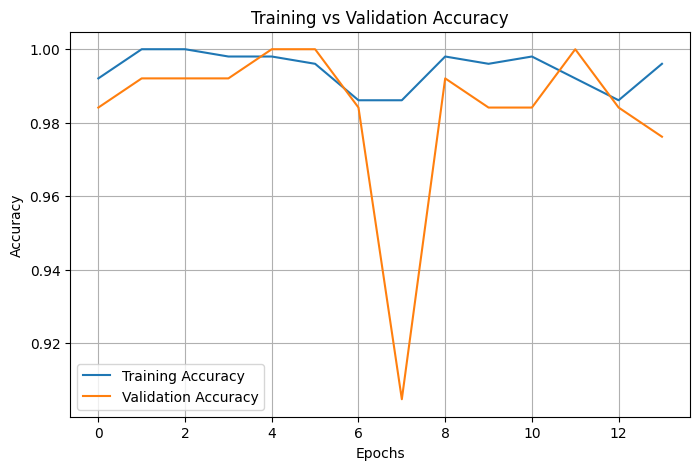

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


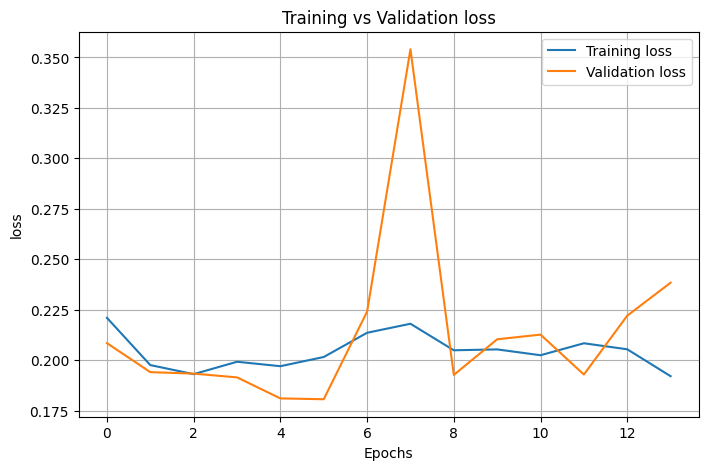

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training vs Validation loss')
plt.legend()
plt.grid(True)

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step


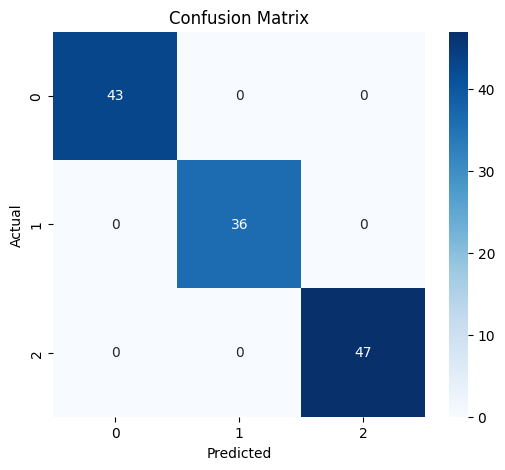


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        47

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_pred = best_model.predict([X24_val, X77_val, Xxe_val])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step
Feature shape: (126, 64)


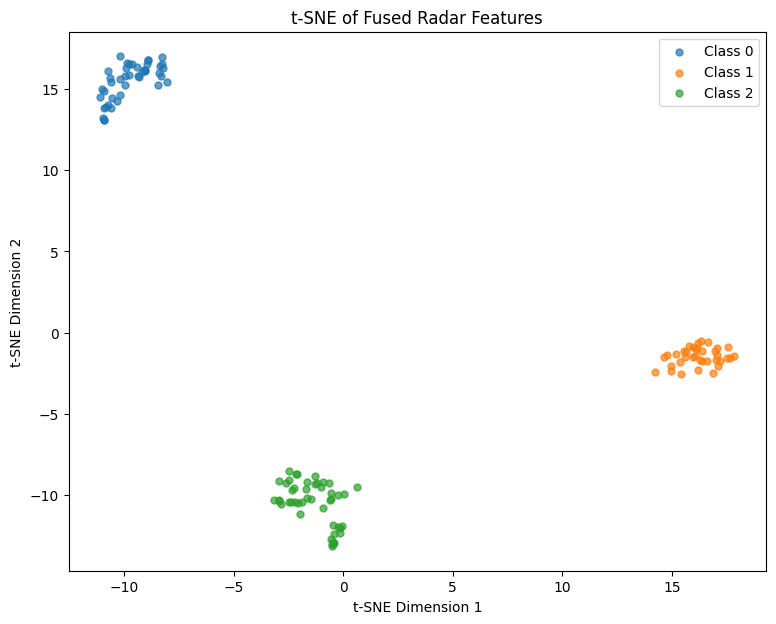

In [ ]:
# Extract features
feature_layer = best_model.layers[-2].output

feature_extractor = tf.keras.Model(
    inputs=best_model.inputs,
    outputs=feature_layer
)

features = feature_extractor.predict(
    [X24_val, X77_val, Xxe_val],
    batch_size=16,
    verbose=1
)

print("Feature shape:", features.shape)

# True validation labels
y_true = np.argmax(y_val_cat, axis=1)

# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    init='pca'
)

features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(9, 7))

for class_id in range(NUM_CLASSES):
    idx = y_true == class_id
    plt.scatter(
        features_2d[idx, 0],
        features_2d[idx, 1],
        label=f"Class {class_id}",
        s=25,
        alpha=0.7
    )

plt.legend()
plt.title("t-SNE of Fused Radar Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


Noise :-

In [ ]:
def add_noise_snr(images, snr_db):

    noisy = []
    for img in images:
        signal_power = np.mean(img**2)
        snr_linear = 10**(snr_db/10)
        noise_power = signal_power / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), img.shape)
        noisy.append(img + noise)

    return np.clip(np.array(noisy), 0, 1)


In [ ]:
X24_10 = add_noise_snr(X24_val, 10)
X77_10 = add_noise_snr(X77_val, 10)
Xxe_10 = add_noise_snr(Xxe_val, 10)

_, acc_10 = best_model.evaluate([X24_10, X77_10, Xxe_10], y_val_cat)
print(f"Accuracy at 10 dB: {acc_10*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 0.9916 - loss: 0.2084
Accuracy at 10 dB: 98.41%


In [ ]:
X24_0 = add_noise_snr(X24_val, 0)
X77_0 = add_noise_snr(X77_val, 0)
Xxe_0 = add_noise_snr(Xxe_val, 0)

_, acc_0 = best_model.evaluate([X24_0, X77_0, Xxe_0], y_val_cat)
print(f"Accuracy at 0 dB: {acc_0*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 562ms/step - accuracy: 0.8290 - loss: 0.5108
Accuracy at 0 dB: 80.16%
